<a href="https://colab.research.google.com/github/AmiriHayes/ASPIRE/blob/main/ASPIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ASPIRE

Created By: Amiri Hayes

Last Updated: 8/26/2023

Contact: amirihayes1 @ gmail.com

See More: [HERE](https://docs.google.com/document/d/1LHZtgJraU883RaD-x6VOwyMwIEAL5cCtvzwVicU4Cn0/edit?usp=sharing)

In [147]:
import os
from google.colab import auth
auth.authenticate_user()

In [109]:
# Google Cloud Storage
project_id = 'alpine-eon-341103'
bucket_name = 'aspire_infrastructure_cache'
!gcloud config set project {project_id}

Updated property [core/project].


In [111]:
# Google FUSE
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

# Mount Directory
mount_path, local_path = bucket_name, f"/mnt/gs/{bucket_name}"
!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  11337      0 --:--:-- --:--:-- --:--:-- 11363
OK
16 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
gcsfuse is already the newest version (1.0.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
I0826 19:19:06.484203 2023/08/26 19:19:06.484160 Start gcsfuse/1.0.1 (Go version go1.20.5) for app "" using mount point: /mnt/gs/aspire_infrastructur

In [112]:
!apt install libspatialindex-dev
!pip install osmnx

In [149]:
import requests
import numpy as np
import osmnx as ox
import networkx as nx
from tqdm import tqdm
from geopy import geocoders
G = geocoders.GeoNames(username='amiri_hayes_')

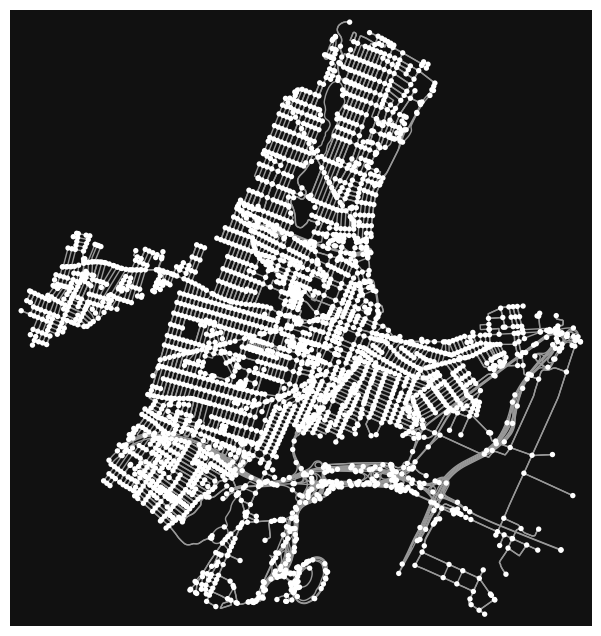

In [82]:
# Example of an OSMNX Graph Network
Graph = ox.graph_from_place("Newark, NJ", network_type="drive")
fig, ax = ox.plot_graph(Graph)

# Data Preprocessing



In [173]:
cities = [
    ("Ironbound", "Newark", "NJ"),
    # ("Bergen Square", "Jersey City", "NJ"),
    # ("Woodcliff", "North Bergen", "NJ")
]

In [124]:
def create_city_database(city, cache = False):
  db = {}
  city_neighborhood, city_name, city_state = city

  db["city_name"] = city_name
  db["city_state"] = city_state
  db["city_neighborhood"] = city_neighborhood

  db["coordinates"] = G.geocode(', '.join(city))[-1]
  db["timezone"] = G.reverse_timezone(db["coordinates"])._raw["timezoneId"]
  db["infrastructure"] = get_infrastructure(city, cache)

  # db["weather_embeddings"] = get_weather(db["coordinates"], db["timezone"])
  # db["safety_embeddings"] = get_crime()
  # db["socioeconomic_embeddings"] = get_socioeconomics()

  return db

In [177]:
# Infrastructure Data (0 / 4)
    # Source: OpenStreetMapsNX
    # Docs: https://osmnx.readthedocs.io/en/stable/
    # Description: Large Graph Networks, saved in Google Cloud

# # Download file from bucket
# download = 'sample-input-1'
# !gsutil cp gs://aspire_infrastructure_cache/{download}.txt /tmp/gsutil_download.txt
# !cat /tmp/gsutil_download.txt

# # Upload file to bucket
# upload = '.sample.txt'
# with open(upload, 'w') as f: f.write('hello world')
# !gsutil cp upload[1:] gs://{bucket_name}/

def get_infrastructure(city, cache = False):
  city_neighborhood, city_name, city_state = city
  cached_file = f'{city_neighborhood}IN{city_name}.npy'

  if cache and cached_file in os.listdir(local_path):
      !gsutil cp gs://{bucket_name}/{cached_file} /tmp/gsc_download.npy
      !cat /tmp/gsc_download.npy
      return
  else:
    city_maps, methods = [], ['walk'] # 'bike', 'drive'
    for method in methods:
        try:
          G = ox.graph_from_place(f"{city_name}, {city_state}", network_type=method)
          city_maps.append(nx.adjacency_matrix(G).todense())
        except Exception: pass

    if cache:
      np.save(cached_file, city_maps)
      !gsutil cp cached_file gs://{bucket_name}/
      !rm cached_file
    return city_maps

In [171]:
# np.save('testnp.npy', dataset[0]["infrastructure"])
# !gsutil -m cp .testnp.npy gs://{bucket_name}/

In [119]:
# Weather & Sunset Data (1 / 4)
    # Source: Open Meteo
    # Docs: https://open-meteo.com/en/docs

def get_weather(coords, timezone):

  weather_data = []
  URL = f"https://api.open-meteo.com/v1/forecast?latitude={coords[0]}&longitude={coords[1]}&daily=sunset&timezone=America%2F{timezone[i]}&past_days=14&hourly=temperature_2m,relativehumidity_2m,windspeed_10m,rain&temperature_unit=fahrenheit"
  response = requests.get(url = URL).json()

  if response:
    # Weather
    temp_avg = round(sum(response["hourly"]["temperature_2m"]) / len(response["hourly"]["temperature_2m"]), 2)
    humidity_avg = round(sum(response["hourly"]["relativehumidity_2m"]) / len(response["hourly"]["relativehumidity_2m"]), 2)
    windspeed_avg = round(sum(response["hourly"]["windspeed_10m"]) / len(response["hourly"]["windspeed_10m"]), 2)
    rain_avg = round(sum(response["hourly"]["rain"]) / len(response["hourly"]["rain"]), 2)

    # Sunset
    sunset_seconds, ftr = [], [60, 1]
    sunset_res = [val.split("T")[1] for val in response["daily"]["sunset"]]
    for val in sunset_res:
      sunset_seconds.append(sum([a*b for a,b in zip(ftr, map(int,val.split(':')))]))
    sunset_avg = round(sum(sunset_seconds) / len(sunset_seconds), 2)

    city_data = [temp_avg, humidity_avg, windspeed_avg, rain_avg, sunset_avg]
    weather_data.append(city_data)

  return weather_data

In [120]:
# Safety Data (2 / 4)
    # Source: FBI
    # Docs: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi

def get_crime():
  i = 0

In [121]:
# Socioeconomic Data (3 / 4)
    # Source: TBD
    # Docs:

def get_socioeconomics():
  i = 0

In [178]:
dataset = []
for city in tqdm(cities):
  dataset.append(create_city_database(city, cache = True))

  0%|          | 0/1 [00:00<?, ?it/s]

CommandException: No URLs matched: cached_file
rm: cannot remove 'cached_file': No such file or directory


100%|██████████| 1/1 [00:35<00:00, 35.81s/it]


In [182]:
name = 'jack'
cached_file = f'{name}INsomewhere.npy'
np.save(cached_file, np.array([0,0,1,0,0], , dtype='float32'))

In [145]:
dataset

[{'city_name': 'Newark',
  'city_state': 'NJ',
  'city_neighborhood': 'Ironbound',
  'coordinates': (40.72457, -74.15297),
  'timezone': 'America/New_York',
  'infrastructure': [array([[0, 1, 0, ..., 0, 0, 0],
          [1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 1, 0],
          [0, 0, 0, ..., 1, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]])]}]

In [152]:
np.save('data.npy', dataset[0]["infrastructure"])

# new_num_arr = np.load('data.npy')

# Machine Learning



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
# Layer One
